In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyedfread import edf
import pickle
from glob import glob
from os.path import join
%matplotlib inline
import seaborn as sns
from scipy import signal
from PSPupil import Preprocessing as PS
from PSPupil import dataset as dt

from scipy import signal
import mne
from scipy.stats import ttest_ind, linregress, f_oneway#, tukey_hsd
from scipy.optimize import curve_fit
import svgutils.transform as sg
from decim.adjuvant import slurm_submit as slu
import matplotlib.colors
import itertools
import scipy
from memoization import cached

baseline_color = 'tab:red'
follow_color = baseline_color
pd_color = 'tab:purple'
control_color = 'tab:orange'

def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

def permutation_cluster_test(x1, x2):
    f, clusters, pvalues, h0=mne.stats.permutation_cluster_test([x1,x2],
                                                                     threshold=dict(start=0, step=0.2))
    return pvalues



# Description

Compute power spectra using Welchs method of cmoplete time series (i.e. per subject and run). 
Also calculate AUC in predefined frequency range. 

Input: 
- Preprocessed pupil time series

Method:
- scipy.welch
- parameters: segment = 60, overlap = segment/2

output
- hdf-file with power frequency values for each subject, run and condition
- conditions refer to preprocessing conditions (specifically currently 2*2, bandpassed and z-scored)

In [2]:
edition = '/Volumes/psp_data/PSP/Pupil_Preprocessed_2024-06-17/'
slu.mkdir_p(join(edition, 'PowerFrequencies'))
slu.mkdir_p(join(edition, 'Figures'))
slu.mkdir_p(join(edition, 'Figures', 'data'))


In [3]:
# parameters for FFT

freq = 60
segment = 60
overlap = segment/2

In [4]:
# calculate CoV weiter unten
CoV = []

## 1. Calculate FFT

In [4]:
groups = {'PSP': dt.runs, 
          'Control': dt.c_runs_g, 
          'PD': dt.ips_runs, 
          'Control_Molly': dt.c_runs_m, 
          'PSP_Molly': dt.runs_new_2}
conditions = {'non_bp_normalized': 'biz',
             'non_bp_non_normalized': 'd_intp',
             'bp_normalized': 'biz_bp',
             'bp_non_normalized':'d_intp_bp'}

In [5]:
@cached
def fft(x, freq, segment, overlap):
    f, p = signal.welch(x, fs=freq, nperseg=segment*freq, noverlap=overlap*freq, detrend='constant')
    fpower = dict(zip(f, p))
    fpower['subject'] = subject
    fpower['session'] = session
    fpower['run'] = run
    fpower['group'] = group
    fpower['condition'] = condition
    return fpower

In [7]:
CoV = []
d=[]

for group, datastructure in groups.items():
    for condition, short in conditions.items():
        if group in ['PSP', 'PSP_Molly']:
            for subject, dictionary in datastructure.items():
                print(group, condition, subject)
                for session, runs in dictionary.items():
                    if runs != None:
                        for run in runs:
                            files = glob(join(edition, group, 'Pupil_Preprocessed_SUB-{0}_{1}_{2}*.hdf'.format(subject, session, run)))
                            for file in files:
                                data = pd.read_hdf(file, key='Pupil')

                                x = data.loc[:, short].fillna(method='bfill').values

                                d.append(fft(x, freq, segment, overlap))
                                di = {'group': 'PSP',
                                  'session': session,
                                'subject': subject,
                                      'group':group,
                                      'condition':condition,
                                 'run': run,
                                 'mean': data.d_intp.mean(),
                                 'std': data.d_intp.std()}
                                CoV.append(di)

                            
        else:
            for subject, runs in datastructure.items():
                print(group, condition, subject)
                for run in runs:
                    session= 'Baseline'
                    files = glob(join(edition, group, 'Pupil_Preprocessed_SUB-{0}_{1}_{2}*.hdf'.format(subject, session, run)))
                    for file in files:
                        data = pd.read_hdf(file, key='Pupil')

                        x = data.loc[:, short].fillna(method='bfill').values
                        d.append(fft(x, freq, segment, overlap))
                        di = {'group': 'PSP',
                          'session': session,
                        'subject': subject,
                              'group':group,
                              'condition':condition,
                         'run': run,
                         'mean': data.d_intp.mean(),
                         'std': data.d_intp.std()}
                        CoV.append(di)
                    


PSP non_bp_normalized 001
PSP non_bp_normalized 002
PSP non_bp_normalized 007
PSP non_bp_normalized 010
PSP non_bp_normalized 012
PSP non_bp_normalized 013
PSP non_bp_normalized 014
PSP non_bp_normalized 018
PSP non_bp_normalized 019
PSP non_bp_normalized 020
PSP non_bp_normalized 021
PSP non_bp_normalized 023
PSP non_bp_normalized 025
PSP non_bp_normalized 026
PSP non_bp_normalized 003
PSP non_bp_normalized 006
PSP non_bp_normalized 009
PSP non_bp_normalized 016
PSP non_bp_normalized 022
PSP non_bp_normalized 024
PSP non_bp_non_normalized 001
PSP non_bp_non_normalized 002
PSP non_bp_non_normalized 007
PSP non_bp_non_normalized 010
PSP non_bp_non_normalized 012
PSP non_bp_non_normalized 013
PSP non_bp_non_normalized 014
PSP non_bp_non_normalized 018
PSP non_bp_non_normalized 019
PSP non_bp_non_normalized 020
PSP non_bp_non_normalized 021
PSP non_bp_non_normalized 023
PSP non_bp_non_normalized 025
PSP non_bp_non_normalized 026
PSP non_bp_non_normalized 003
PSP non_bp_non_normalized 006


In [8]:
PowerSpectra = pd.DataFrame(d)
PowerSpectra.to_hdf(join(edition, 'PowerFrequencies', 'PowerSpectra_{0}_{1}_pd.hdf'.format(segment, overlap)), key='data')


/Users/kenohagena/anaconda3/lib/python3.6/site-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)


In [9]:
CoV = pd.DataFrame(CoV)
CoV.to_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')

In [6]:
# Import above saved data to avoid rerunning

CoV = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
PowerSpectra = pd.read_hdf(join(edition, 'PowerFrequencies', 'PowerSpectra_{0}_{1}_pd.hdf'.format(segment, overlap)), key='data')


In [7]:
# Average per subject

PowerSpectra_avg = PowerSpectra.groupby(['subject', 'session', 'group', 'condition']).mean().reset_index()

PowerSpectra_avg = PowerSpectra_avg

## 2. Calculate AUC and store

In [8]:
condition = 'bp_non_normalized'
compare_group = ['PSP', 'PD', 'Control'] # fit average 1/f curve based on these groups
auc_range = [1/16, 1/2]

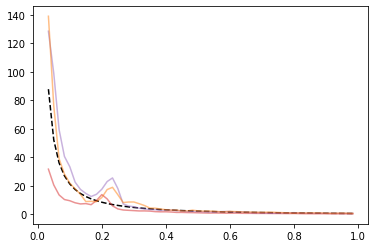

In [9]:
# Fit Powerlaw function to data from compare groups for reference for AUC calculation

stacked = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.group.isin(compare_group))&(PowerSpectra_avg.session == 'Baseline')].\
set_index(['subject', 'group']).drop(['session', 'condition'], axis=1).stack().reset_index().rename(columns={'level_2': 'freq',
                                                                                       0: 'power'})

stacked.freq = stacked.freq.astype(float)
stacked = stacked.loc[(stacked.freq > 1/32)&(stacked.freq < 1)]

X=stacked.freq.values
y=stacked.power.values
popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)

X=stacked.freq.unique()
plt.plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')

plt.plot(stacked.loc[stacked.group == 'PSP'].groupby('freq').mean().reset_index().freq.values,
        stacked.loc[stacked.group == 'PSP'].groupby('freq').mean().reset_index().power.values,
        color=baseline_color, alpha=.5)

plt.plot(stacked.loc[stacked.group == 'PD'].groupby('freq').mean().reset_index().freq.values,
        stacked.loc[stacked.group == 'PD'].groupby('freq').mean().reset_index().power.values,
        color=pd_color, alpha=.5)

plt.plot(stacked.loc[stacked.group == 'Control'].groupby('freq').mean().reset_index().freq.values,
        stacked.loc[stacked.group == 'Control'].groupby('freq').mean().reset_index().power.values,
        color=control_color, alpha=.5)

x = stacked.freq.unique()
auc_x = x[(x<=auc_range[1])&(x>=auc_range[0])].astype(float)
auc_y = func_powerlaw(auc_x, *popt)


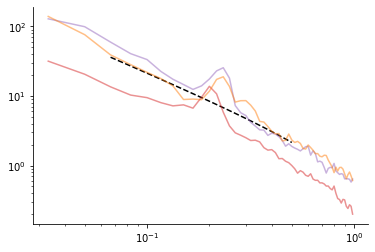

In [10]:
# Visual sanity check: Plot actual compare AUC range

f, ax = plt.subplots()
ax.plot(auc_x, auc_y, color='black', linestyle='--')

ax.plot(stacked.loc[stacked.group == 'PSP'].groupby('freq').mean().reset_index().freq.values,
        stacked.loc[stacked.group == 'PSP'].groupby('freq').mean().reset_index().power.values,
        color=baseline_color, alpha=.5)

ax.plot(stacked.loc[stacked.group == 'PD'].groupby('freq').mean().reset_index().freq.values,
        stacked.loc[stacked.group == 'PD'].groupby('freq').mean().reset_index().power.values,
        color=pd_color, alpha=.5)

ax.plot(stacked.loc[stacked.group == 'Control'].groupby('freq').mean().reset_index().freq.values,
        stacked.loc[stacked.group == 'Control'].groupby('freq').mean().reset_index().power.values,
        color=control_color, alpha=.5)


ax.set(xscale='log', yscale='log')
sns.despine()

In [12]:
auc = []
df = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)].set_index(['subject', 'group', 'session'])
for i in df.index:
    #print(i)
    d = df.loc[i, auc_x]
    auc.append({'subject':i[0],
               'group': i[1],
               'condition': condition,
                'session': i[2],
               'auc': np.trapz(d - auc_y, x=auc_x)})
auc = pd.DataFrame(auc)
        

        

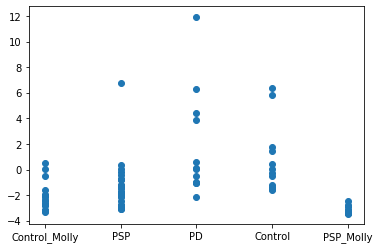

In [19]:
plt.scatter(auc.group, auc.auc)

In [14]:
# Store AUC and parameters of reference line
auc.to_hdf(join(edition, 'PowerFrequencies', 'auc_{}.hdf'.format(condition)), key='data')

np.save(join(edition, 'Figures', 'data', 'popt.npy'),  popt) 
np.save(join(edition, 'Figures', 'data', 'auc_x.npy'),  auc_x) 

## 3. Calculate cluster permutation testing and export

In [34]:
# just loc for given condition and separately per group & session of interest

psp_baseline_avg = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&\
                     (PowerSpectra_avg.session == 'Baseline')&\
                     (PowerSpectra_avg.group == 'PSP')].drop(['group', 'condition'], axis=1).set_index('subject')

psp_followup_avg = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&\
                     (PowerSpectra_avg.session == 'Followup')&\
                     (PowerSpectra_avg.group == 'PSP')].drop(['group', 'condition'], axis=1).set_index('subject')

ctrl_fpower_avg = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&\
                     (PowerSpectra_avg.session == 'Baseline')&\
                     (PowerSpectra_avg.group == 'Control')].drop(['group', 'condition'], axis=1).set_index('subject')

pd_fpower_avg = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&\
                     (PowerSpectra_avg.session == 'Baseline')&\
                     (PowerSpectra_avg.group == 'PD')].drop(['group', 'condition'], axis=1).set_index('subject')

## DROP PD 12
pd_fpower_avg = pd_fpower_avg.drop('12')

In [36]:
#data for permutation testint
d = psp_baseline_avg.drop(['session'], axis=1).unstack().reset_index()
d.level_0 = d.level_0.astype(float)
base = d.loc[(d.level_0 >=1/32)&(d.level_0 <=1)]
base = base.pivot(columns = 'level_0', index='subject')

d = ctrl_fpower_avg.drop(['session'], axis=1).unstack().reset_index()
d.level_0 = d.level_0.astype(float)
cont = d.loc[(d.level_0 >=1/32)&(d.level_0 <=1)]
cont = cont.pivot(columns = 'level_0', index='subject')

d = psp_followup_avg.drop(['session'], axis=1).unstack().reset_index()
d.level_0 = d.level_0.astype(float)
fol = d.loc[(d.level_0 >=1/32)&(d.level_0 <=1)]
fol = fol.pivot(columns = 'level_0', index='subject')

d = pd_fpower_avg.drop(['session'], axis=1).unstack().reset_index()
d.level_0 = d.level_0.astype(float)
pdg = d.loc[(d.level_0 >=1/32)&(d.level_0 <=1)]
pdg = pdg.pivot(columns = 'level_0', index='subject')

permut_x = pdg.droplevel(0, axis=1).columns

pvals_psp_c = permutation_cluster_test(base.values, 
                         cont.values)
print(pvals_psp_c<.05)


pvals_psp_pd = permutation_cluster_test(base.values, 
                         pdg.values)
print(pvals_psp_pd<.05)


pvals_pd_cont = permutation_cluster_test(cont.values, 
                         pdg.values)
print(pvals_pd_cont<.05)

stat_fun(H1): min=0.022262 max=10.415449
Running initial clustering
Using 53 thresholds from 0.00 to 10.40 for TFCE computation (h_power=2.00, e_power=0.50)
Found 59 clusters
Permuting 1023 times...
[.......................................  ] 96.97%  \   Computing cluster p-values
Done.
[False False False False False False False False False False False False
  True  True  True False False False False False False False False False
  True False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False]
stat_fun(H1): min=0.313153 max=13.183248
Running initial clustering
Using 66 thresholds from 0.00 to 13.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 59 clusters
Permuting 1023 times...
[.......................................  ] 96.97%  \   Computing cluster p-values
Done.
[ True  True False False False False False False False False Fal

In [37]:
np.save(join(edition, 'Figures', 'data', 'permut_x.npy'),  permut_x) 
np.save(join(edition, 'Figures', 'data', 'pvals_psp_pd.npy'),  pvals_psp_pd) 
np.save(join(edition, 'Figures', 'data', 'pvals_psp_c.npy'),  pvals_psp_c) 
# pvals_pd_cont non-significant so no export necessary

psp_followup_avg.to_hdf(join(edition, 'Figures', 'data', 'psp_followup_avg.hdf'), key='data')
psp_baseline_avg.to_hdf(join(edition, 'Figures', 'data', 'psp_baseline_avg.hdf'), key='data')
pd_fpower_avg.to_hdf(join(edition, 'Figures', 'data', 'pd_fpower_avg.hdf'), key='data')
ctrl_fpower_avg.to_hdf(join(edition, 'Figures', 'data', 'ctrl_fpower_avg.hdf'), key='data')

## 4. Plot Stuff (not essential, Figures elsewhere)

### 4.1 Normalization yes / no

"\nax[i].set(ylim = (0, data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()/1.5))\n\n"

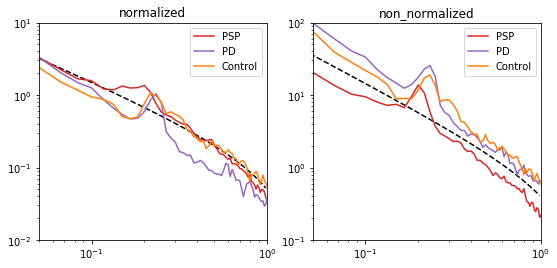

In [21]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['non_bp_normalized', 'non_bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
    ax[i].plot(data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color=baseline_color, label='PSP')
    
    ax[i].plot(data.loc[(data.group == 'PD')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PD')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color=pd_color, label='PD')
    
    ax[i].plot(data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color=control_color, label = 'Control')
    
    ax[i].set(xlim=(0.05, 1),
             title = condition[7:])
    ax[i].set(xscale='log', yscale='log')

    ax[i].legend()

    
ax[0].set(ylim=(0.01, 10))
ax[1].set(ylim=(0.1, 100))

    
f.savefig(join(edition, 'Figures', 'PowerSpectra_non_bp_old.png'), dpi=600)

'''
ax[i].set(ylim = (0, data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()/1.5))

'''

[(0.1, 100)]

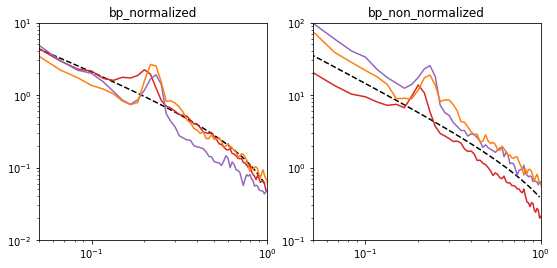

In [20]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['bp_normalized', 'bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
    ax[i].plot(data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color=baseline_color, label='PSP')
    
    ax[i].plot(data.loc[(data.group == 'PD')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PD')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color=pd_color, label='PD')
    
    ax[i].plot(data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color=control_color, label = 'Control')
    
    ax[i].set(xlim=(0.05, 1),
             ylim = (0, data.loc[(data.group == 'PD')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()),
             title = condition)
    ax[i].set(yscale='log', xscale='log')
    
    
ax[0].set(ylim=(0.01, 10))
ax[1].set(ylim=(0.1, 100))

### 4.2 Compare datasets
- Sanity Check: Same trend in different dataset (Molly PSP vs. HC)

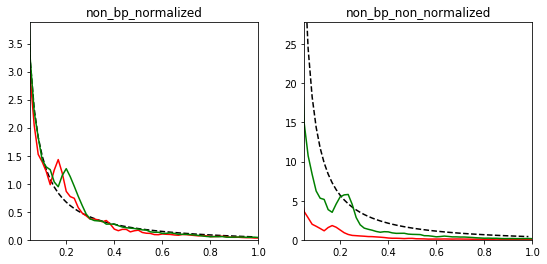

In [22]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['non_bp_normalized', 'non_bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
    ax[i].plot(data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PSP_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='red')
    
    ax[i].plot(data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'Control_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='green')
    
    ax[i].set(xlim=(0.05, 1),
             ylim = (0, data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()/1.5),
             title = condition)
    

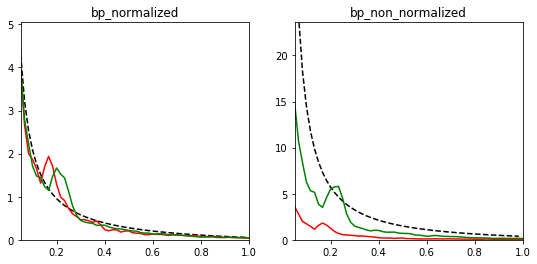

In [23]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['bp_normalized', 'bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
    ax[i].plot(data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PSP_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='red')
    
    ax[i].plot(data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'Control_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='green')
    
    ax[i].set(xlim=(0.05, 1),
             ylim = (0, data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()/1.5),
             title = condition)
    


### 4.2 Pool datasets

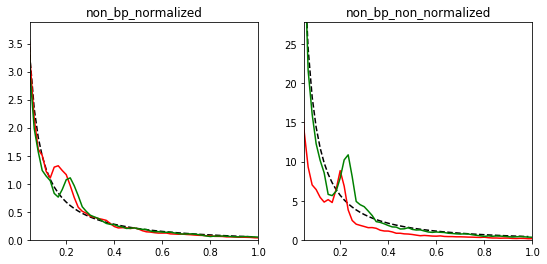

In [24]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['non_bp_normalized', 'non_bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
    ax[i].plot(data.loc[(data.group.isin(['PSP', 'PSP_Molly']))].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group.isin(['PSP', 'PSP_Molly']))].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='red')
    
    ax[i].plot(data.loc[(data.group.isin(['Control', 'Control_Molly']))].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group.isin(['Control', 'Control_Molly']))].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='green')
    
    ax[i].set(xlim=(0.05, 1),
             ylim = (0, data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()/1.5),
             title = condition)
    
f.savefig(join(edition, 'Figures', 'PowerSpectra_non_bp_Molly.png'), dpi=600)

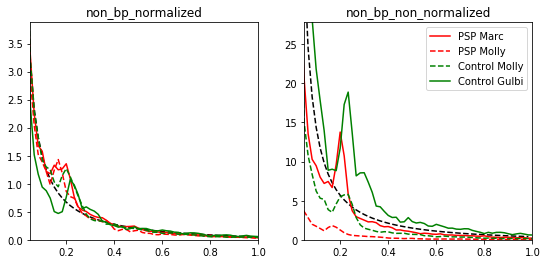

In [25]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['non_bp_normalized', 'non_bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
   
    ax[i].plot(data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='red', label='PSP Marc')
    
    ax[i].plot(data.loc[(data.group == 'PSP_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'PSP_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='red', linestyle='--', label='PSP Molly')
    
    ax[i].plot(data.loc[(data.group == 'Control_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'Control_Molly')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='green', linestyle='--', label='Control Molly')
    
    ax[i].plot(data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().index.values,
                       data.loc[(data.group == 'Control')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().values,
              color='green', label='Control Gulbi')
    
    ax[i].set(xlim=(0.05, 1),
             ylim = (0, data.loc[(data.group == 'PSP')].drop(['condition', 'subject', 'session', 'group'], axis=1).mean().max()/1.5),
             title = condition)
    
ax[1].legend()    
f.savefig(join(edition, 'Figures', 'PowerSpectra_non_bp_pooled.png'), dpi=600)

### 4.3 Plot single subjects

#### PSP

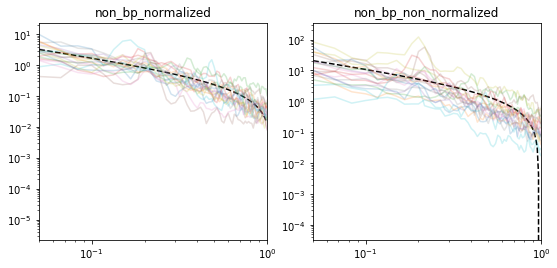

In [37]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))

for i, condition in enumerate(['non_bp_normalized', 'non_bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')&(PowerSpectra_avg.group == 'PSP')]
    
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    ax[i].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
    
    for sub in data.subject.unique():
        d = data.loc[data.subject == sub].drop(['condition',  'subject', 'session', 'group'], axis=1)
        ax[i].plot(d.mean().index.values,
                   d.mean().values, label = sub, alpha=.2)


    
    ax[i].set(xlim=(0.05, 1), xticks=[1/20, 1/5, 1/3, 1/2, 1],
             title = condition, xscale='log', yscale='log')
    


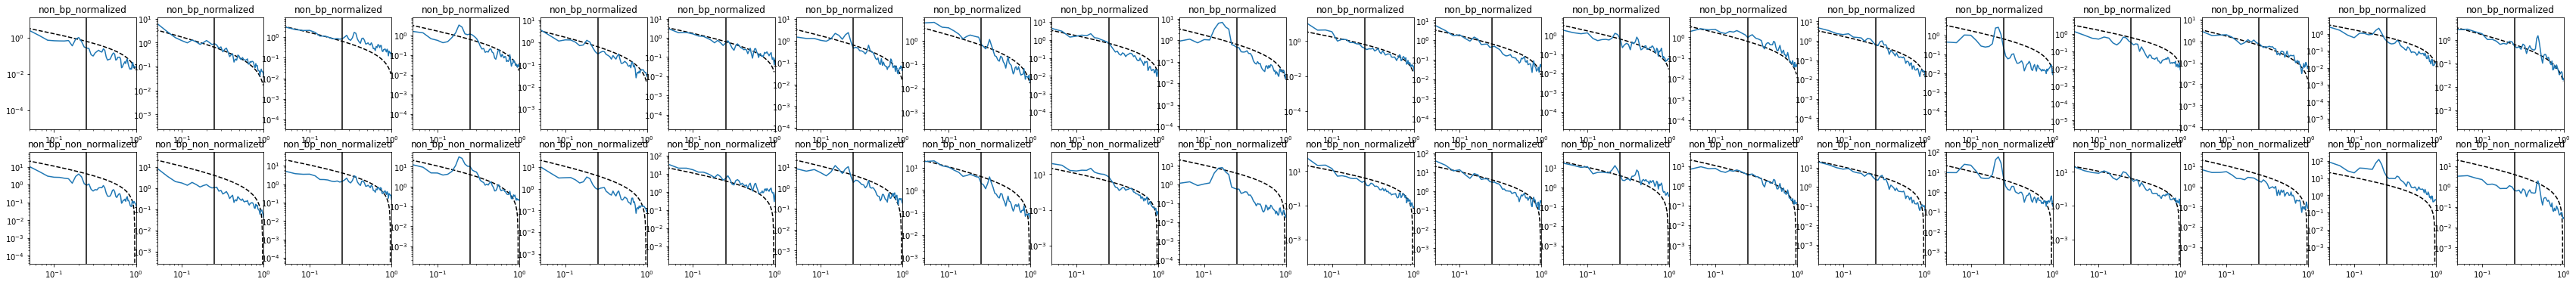

In [49]:
f, ax = plt.subplots(2, 20, figsize=(60, 6))
for i, condition in enumerate(['non_bp_normalized', 'non_bp_non_normalized']):
    data = PowerSpectra_avg.loc[(PowerSpectra_avg.condition == condition)&(PowerSpectra_avg.session == 'Baseline')&(PowerSpectra_avg.group == 'PSP')]
    d = data.drop(['condition', 'subject', 'session', 'group'], axis=1).stack().reset_index().rename(columns={'level_1': 'freq',
                                                                                       0: 'power'})
    d.freq = d.freq.astype(float)
    d = d.loc[(d.freq > 1/32)&(d.freq < 1)]
    X=d.freq.values
    y=d.power.values
    popt, pcov = curve_fit(func_powerlaw, X, y, p0 = np.asarray([-1,10**5,0]), maxfev=800)
    X=d.freq.unique()
    
    for j, sub in enumerate(data.subject.unique()):
        ax[i, j].plot(X, func_powerlaw(X, *popt), color='black', linestyle='--')
        da = data.loc[data.subject == sub].drop(['condition',  'subject', 'session', 'group'], axis=1)
        ax[i, j].plot(da.mean().index.values,
                   da.mean().values, label = sub)
        
        ax[i, j].set(xlim=(0.05, 1), xticks=[0.05, 0,25, 0.5, 1],
             title = condition, xscale='log', yscale='log')
        
        ax[i, j].axvline(0.25, color='black')
        
        